In [1]:
import uk_covid19 as cv
import pandas as pd
import numpy as np
import json

from datetime import date, datetime, timedelta

import matplotlib.pyplot as plt
import matplotlib.dates as mdates

In [2]:
# Get data from API. (See https://coronavirus.data.gov.uk/developers-guide#structure-metrics)
filters = ["areaType=region", "areaName=East Midlands"]
dataStructure = {   
    "date": "date", 
    "areaName": "areaName", 
    "maleCases": "maleCases",
    "femaleCases": "femaleCases"
} 

objCV19 = cv.Cov19API(filters=filters, structure=dataStructure) 

apiResult = objCV19.get_json()


`apiResult` is a python dictionary object that we need to parse into a flat dataframe. 

It has various keys but the data is stored in `apiResult["data"]`.

In [3]:
df_male = pd.json_normalize(data=apiResult["data"], record_path=["maleCases"], meta=["date", "areaName"], record_prefix="male_")
df_female = pd.json_normalize(data=apiResult["data"], record_path=["femaleCases"], meta=["date", "areaName"], record_prefix="female_")

In [4]:
df_male = df_male.rename(columns={"male_age": "age", "male_value": "maleCases", "male_rate": "maleRate"})
df_female = df_female.rename(columns={"female_age": "age", "female_value": "femaleCases", "female_rate": "femaleRate"})

In [5]:
df_male.head()

,age,maleCases,maleRate,date,areaName
0,80_to_84,1083,1906.9,2020-10-29,East Midlands
1,35_to_39,2419,1659.0,2020-10-29,East Midlands
2,60_to_64,1767,1280.7,2020-10-29,East Midlands
3,0_to_4,643,463.9,2020-10-29,East Midlands
4,45_to_49,2333,1716.6,2020-10-29,East Midlands


In [6]:
df_male = df_male.set_index(["date", "areaName", "age"])
df_female = df_female.set_index(["date", "areaName", "age"])

In [7]:
df = pd.concat([df_male, df_female], axis=1, join='inner')

In [8]:
df["TotalRate"] = df["maleRate"]+df["femaleRate"]
df.head()

maleCases  maleRate  femaleCases  \
date       areaName      age                                          
2020-10-29 East Midlands 80_to_84       1083    1906.9         1118   
                         35_to_39       2419    1659.0         2724   
                         60_to_64       1767    1280.7         1757   
                         0_to_4          643     463.9          635   
                         45_to_49       2333    1716.6         2995   

                                   femaleRate  TotalRate  
date       areaName      age                              
2020-10-29 East Midlands 80_to_84      1597.7     3504.6  
                         35_to_39      1795.7     3454.7  
                         60_to_64      1241.0     2521.7  
                         0_to_4         483.9      947.8  
                         45_to_49      2156.2     3872.8

In [9]:
# Dataframe was combined using a key made of date, areaName and age,  we now want to reset the index so those columns are available.
df = df.reset_index()

# Remove dates older than 62 days ago and the newest few depending on time of day.

earliestDate = date.today() - timedelta(days=62)
earliestDate = earliestDate.strftime('%Y-%m-%d')

now = datetime.now()

current_time = now.strftime("%H:%M:%S")

if current_time < "17:00:00":
    timeDeltaDays = 2
else:
    timeDeltaDays = 1

latestDate = date.today() - timedelta(days=timeDeltaDays)
latestDate = latestDate.strftime('%Y-%m-%d')

df = df[(df["date"] >= earliestDate) & (df["date"] < latestDate)]

df = df.sort_values(by=["date", "age"])

df.tail(20)

,date,areaName,age,maleCases,maleRate,femaleCases,femaleRate,TotalRate
38,2020-10-27,East Midlands,90+,629,4675.5,1360,4509.9,9185.4
29,2020-10-28,East Midlands,0_to_4,643,463.9,635,483.9,947.8
36,2020-10-28,East Midlands,10_to_14,825,548.4,841,582.0,1130.4
32,2020-10-28,East Midlands,15_to_19,3897,2702.2,5191,3758.0,6460.2
34,2020-10-28,East Midlands,20_to_24,4767,3393.2,5454,4084.0,7477.2
30,2020-10-28,East Midlands,25_to_29,2781,1695.4,3313,2196.0,3891.4
28,2020-10-28,East Midlands,30_to_34,2661,1664.4,3028,1982.7,3647.1
31,2020-10-28,East Midlands,35_to_39,2419,1659.0,2724,1795.7,3454.7
21,2020-10-28,East Midlands,40_to_44,2230,1541.2,2679,1778.8,3320.0
19,2020-10-28,East Midlands,45_to_49,2328,1712.9,2994,2155.5,3868.4


In [10]:
df["ageType"] = df["age"].str.find("_")

df = df[df["ageType"] != 1]
df.head(20)

df["ageStart"] = df["age"].str[:2]


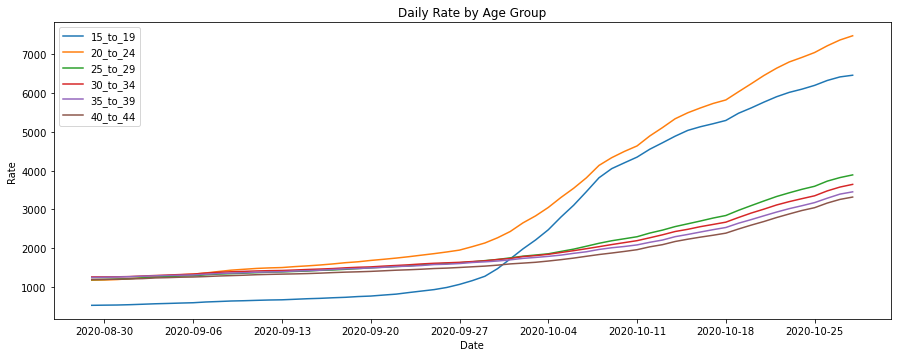

In [11]:
# Create figure.
fig = plt.figure(figsize=[15,12])
fig.set_grid = True
ax1 = fig.add_subplot(2,1,1)

locator = mdates.DayLocator(interval = 7)

ax1.set_title("Daily Rate by Age Group")
ax1.set_xlabel("Date")
ax1.set_ylabel("Rate")

ax1.xaxis.set_major_locator(locator)

#ages = list(df.age.unique())
#ages.remove("90+")

ages = list(["15_to_19" , 
            "20_to_24",
            "25_to_29",
            "30_to_34",
            "35_to_39",
            "40_to_44"])


for a in ages:
    dfByAge = df.loc[df["age"] == a]
    ax1.plot(dfByAge["date"], dfByAge["TotalRate"], label=a)

ax1.legend(loc="upper left")
fig.show()